## Dataset Information

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

For training the models, we provide a labelled dataset of 31,962 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

## Import modules

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
%matplotlib inline

## Loading the dataset

In [2]:
df = pd.read_csv('Twitter Sentiments.csv')

## Preprocessing the dataset

In [3]:
# function to remove pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [4]:
# remove twitter handles
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [5]:
# remove special characters, numbers and punctuations
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

C:\Users\RAHUL\AppData\Local\Temp/ipykernel_14576/2811566831.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")


In [6]:
# remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAHUL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# individual words considered as tokens
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())

In [8]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])

In [9]:
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['clean_tweet'] = tokenized_tweet
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit use caus offer wheelchair v...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguid societi #motiv


## Exploratory Data Analysis

In [10]:
# function to extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags    

In [11]:
# extract hashtags from non-racist/sexist tweets
ht_positive = hashtag_extract(df['clean_tweet'][df['label']==0])

# extract hashtags from racist/sexist tweets
ht_negative = hashtag_extract(df['clean_tweet'][df['label']==1])

In [12]:
# unnest the nested-list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [13]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


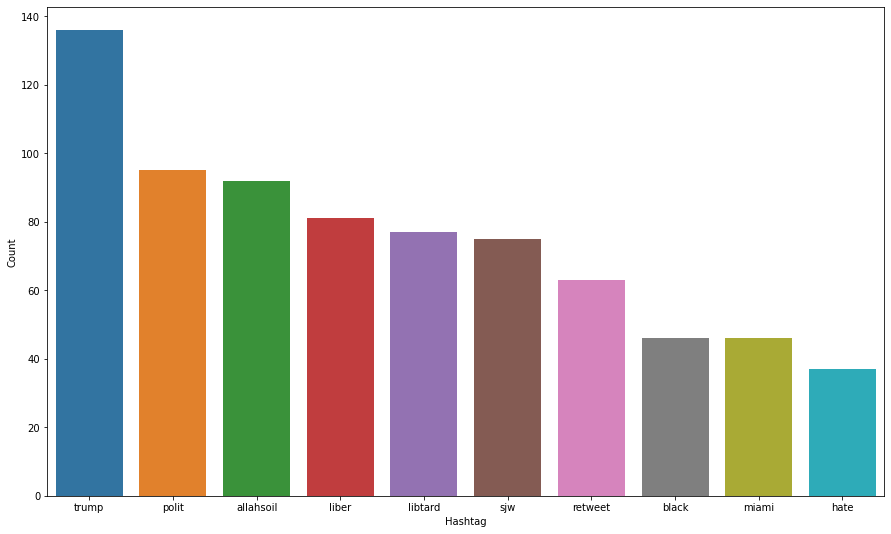

In [17]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [15]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


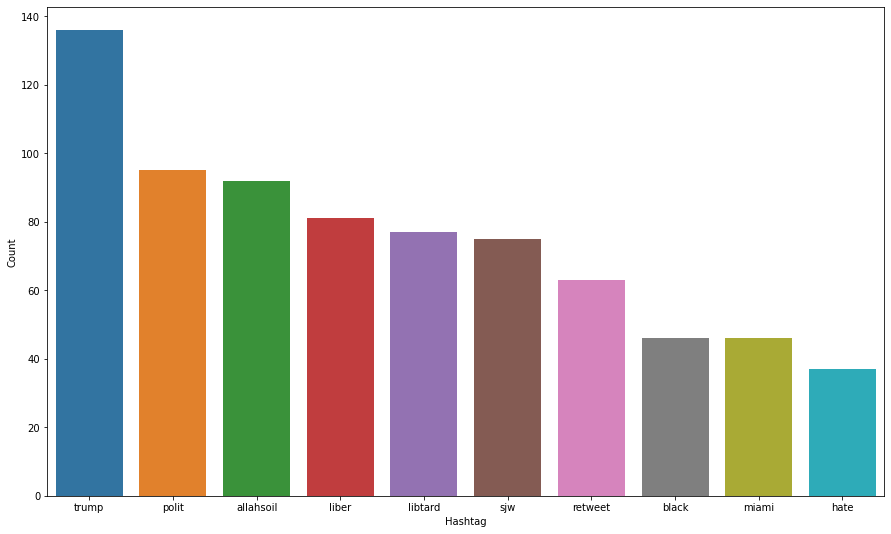

In [18]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

## Input Split

In [19]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state=42, test_size=0.25)

## Model Training using Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [22]:
# training
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [23]:
# testing
pred = model.predict(x_test)
# confusion matrix
cm= confusion_matrix(y_test, pred)
cm

array([[7178,  254],
       [ 258,  301]], dtype=int64)

In [24]:
#f1 of model
f1_score(y_test, pred)

0.5403949730700179

In [25]:
#accuracy of model
accuracy_score(y_test,pred)

0.9359279189087724